<a href="https://colab.research.google.com/github/NoamBarak/Suicide-Rates-Overview-1985-to-2016/blob/main/Suicide_Rate_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mlens


import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from mlens.ensemble import SuperLearner
from mlens.model_selection import Evaluator
from mlens.metrics import make_scorer
from mlens.metrics.metrics import rmse

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

from sklearn.metrics import accuracy_score


!git clone https://github.com/NoamBarak/Suicide-Rates-Overview-1985-to-2016
data = pd.read_csv('/content/Suicide-Rates-Overview-1985-to-2016/master.csv')



fatal: destination path 'Suicide-Rates-Overview-1985-to-2016' already exists and is not an empty directory.


## **Data Preprocessing**

In [ ]:
data.columns = ['country', 'year', 'sex', 'age', 'suicide_no',
                'population', 'suicide_per100k', 'country-year', 'HDI for year',
                'gdp_for_year', 'gdp_per_capita', 'generation']   # Remame columns

data_for_graphs = data.copy()  # Save all columns (for visualizing part)

data = data.drop(['HDI for year', 'country-year',
                  'generation', 'population', 'suicide_no'], axis = 1)  # Drop columns
data = data.dropna()  # Drop null rows

data['gdp_for_year'] = data.gdp_for_year.str.split(',').str.join('').astype(float)  # Convert values to floats
data_before_encoding = data.copy()  # Save original data

label_encoder = sklearn.preprocessing.LabelEncoder()
robust_scaler = RobustScaler()

# Categorical features
cat_features=[x for x in data_before_encoding.columns if (data_before_encoding[x].dtype=="str" or data_before_encoding[x].dtype=="object")]

for column in cat_features:
    data[column] = label_encoder.fit_transform(data[column])

# Numerical features
num_features = []
for column in data.columns:
  if column not in cat_features:
    num_features.append(column)

data[num_features] = robust_scaler.fit_transform(data[num_features])


# Splitting the data
y = data['suicide_per100k']
X = data.drop(['suicide_per100k'],axis=1)
data_before_encoding = data_before_encoding.drop(['suicide_per100k'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 12)


In [ ]:
# Store the model performance results
model_name = []
score_train = []
score_test = []
rmse_train = []
rmse_test = []

# Store results (for each model)
def models_results(model, score_train_res,score_test_res,rmse_train_res,rmse_test_res):
    model_name.append(model)
    score_train.append(round(score_train_res, 3))
    score_test.append(round(score_test_res, 3))
    rmse_train.append(round(rmse_train_res, 3))
    rmse_test.append(round(rmse_test_res, 3))

# Print results
def print_results(model, score_train_res,score_test_res,rmse_train_res,rmse_test_res):
  print(model + ": Score- training set: {:.3f}".format(score_train_res))
  print(model + ": Score- test set: {:.3f}".format(score_test_res))
  print(f"\n{model}: RMSE- training set:", rmse_train_res)
  print(f"{model}: RMSE- testing set:", rmse_test_res)

## **Linear Regression using our own net**


In [ ]:

class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.fc0 = nn.Linear(6, 64)
        self.fc1 = nn.Linear(64, 1)
        self.double()

    def forward(self, x):
        x = torch.sigmoid(self.fc0(x))
        x = torch.sigmoid(self.fc1(x))
        return x

class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.fc0 = nn.Linear(6, 128)
        self.fc1 = nn.Linear(128, 1)
        self.double()

    def forward(self, x):
        x = torch.relu(self.fc0(x))
        x = torch.relu(self.fc1(x))
        return x

class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.fc0 = nn.Linear(6, 128)
        self.fc1 = nn.Linear(128, 128)
        self.fc2 = nn.Linear(128, 1)
        self.double()

    def forward(self, x):
        x = torch.sigmoid(self.fc0(x))
        x = torch.dropout(x, p=0.3,  train=True)
        x = torch.relu(self.fc1(x))
        x = torch.dropout(x, p=0.2,  train=True)
        x = torch.relu(self.fc2(x))
        return x

DataSetDemographic

In [ ]:
# Dataset defenition
class DataSetDemographic(Dataset):
    def __init__(self, data, transformer=None):
        self.data = data
        self.transformer = transformer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        series = self.data.iloc[idx, 0:]
        label = torch.tensor(series['suicide_per100k'])
        series = series.drop('suicide_per100k')
        input = torch.tensor(series.values)
        if self.transformer is not None:
            input = self.transformer(input)
        return input, label

Train and Predict methods

In [ ]:
# hyper parameters
lr = 0.01
momentum = 0.7
epochs = 10

#train method
def train_data(net, dataloader, epochs=10):
    net.train()
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    for epoch in range(epochs):
        epoch_loss = 0.0
        small_loss = 0.0
        for i, (input, label) in enumerate(dataloader):
            optimizer.zero_grad()  # zero the parameter gradients
            output = net(input)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            small_loss += loss.item()
            epoch_loss += loss.item()
    return net

def predict(model, dataloader):
    model.eval()
    y_hat = []
    with torch.no_grad():
        for i, (input, label) in enumerate(dataloader):
            output = model(input)
            if len(output) > 0:
                y_hat = y_hat + output.tolist()
            else:
                y_hat.append(output)
    return y_hat

Main

In [ ]:
    batch_size = 64
    # Generating dataloader from train set and from test set
    train_dataloader, test_dataloader = X_train.copy(), X_test.copy()
    train_dataloader['suicide_per100k'], test_dataloader['suicide_per100k'] = y_train.copy(), y_test.copy()
    train_dataloader = DataLoader(DataSetDemographic(train_dataloader), batch_size=batch_size)
    test_dataloader = DataLoader(DataSetDemographic(test_dataloader), batch_size=batch_size)

    def score(y_true, y_pred):
      u = ((y_true - y_pred) ** 2).sum()
      v = ((y_true - y_true.mean()) ** 2).sum()
      retval = (1 - (u/v))
      return retval


In [ ]:
# checking net 1
net = Net1()
net.double()
net = train_data(net, train_dataloader, epochs=epochs)

y_train_net1_predict = predict(net, train_dataloader)
y_test_net1_predict = predict(net, test_dataloader)

y_train_net1_predict = np.concatenate(y_train_net1_predict)
y_test_net1_predict = np.concatenate(y_test_net1_predict)
# Calculate scores
score_train_net1 = score(y_train, y_train_net1_predict)
score_test_net1 = score(y_test, y_test_net1_predict)
rmse_train_net1 = np.sqrt(mean_squared_error(y_train, y_train_net1_predict))
rmse_test_net1 = np.sqrt(mean_squared_error(y_test, y_test_net1_predict))

# Results
print_results('Net1',score_train_net1, score_test_net1, rmse_train_net1, rmse_test_net1)
models_results('Net1',score_train_net1, score_test_net1, rmse_train_net1, rmse_test_net1)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([48])) that is different to the input size (torch.Size([48, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Net1: Score- training set: -0.001
Net1: Score- test set: -0.002

Net1: RMSE- training set: 1.2008328058360807
Net1: RMSE- testing set: 1.2370258098145037


In [ ]:
# checking net 2
net = Net2()
net.double()
net = train_data(net, train_dataloader, epochs=epochs)

y_train_net2_predict = predict(net, train_dataloader)
y_test_net2_predict = predict(net, test_dataloader)

y_train_net2_predict = np.concatenate(y_train_net2_predict)
y_test_net2_predict = np.concatenate(y_test_net2_predict)
# Calculate scores
score_train_net2 = score(y_train, y_train_net2_predict)
score_test_net2 = score(y_test, y_test_net2_predict)
rmse_train_net2 = np.sqrt(mean_squared_error(y_train, y_train_net2_predict))
rmse_test_net2 = np.sqrt(mean_squared_error(y_test, y_test_net2_predict))

# Results
print_results('Net2',score_train_net2, score_test_net2, rmse_train_net2, rmse_test_net2)
models_results('Net2',score_train_net2, score_test_net2, rmse_train_net2, rmse_test_net2)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([48])) that is different to the input size (torch.Size([48, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Net2: Score- training set: -0.129
Net2: Score- test set: -0.131

Net2: RMSE- training set: 1.2757468987202507
Net2: RMSE- testing set: 1.314524206592041


In [ ]:
# checking net 3
net = Net3()
net.double()
net = train_data(net, train_dataloader, epochs=epochs)

y_train_net3_predict = predict(net, train_dataloader)
y_test_net3_predict = predict(net, test_dataloader)

y_train_net3_predict = np.concatenate(y_train_net3_predict)
y_test_net3_predict = np.concatenate(y_test_net3_predict)
# Calculate scores
score_train_net3 = score(y_train, y_train_net3_predict)
score_test_net3 = score(y_test, y_test_net3_predict)
rmse_train_net3 = np.sqrt(mean_squared_error(y_train, y_train_net3_predict))
rmse_test_net3 = np.sqrt(mean_squared_error(y_test, y_test_net3_predict))

# Results
print_results('Net3',score_train_net3, score_test_net3, rmse_train_net3, rmse_test_net3)
models_results('Net3',score_train_net3, score_test_net3, rmse_train_net3, rmse_test_net3)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([48])) that is different to the input size (torch.Size([48, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Net3: Score- training set: 0.000
Net3: Score- test set: -0.000

Net3: RMSE- training set: 1.2005068376253458
Net3: RMSE- testing set: 1.2363133857984472


## **Linear Regression**

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_test_lr = lr.predict(X_test)
y_train_lr = lr.predict(X_train)

# Calculate scores
score_train_lr = lr.score(X_train, y_train)
score_test_lr = lr.score(X_test, y_test)
rmse_train_lr = np.sqrt(mean_squared_error(y_train, y_train_lr))
rmse_test_lr = np.sqrt(mean_squared_error(y_test, y_test_lr))

# Results
print_results('Linear Regression', score_train_lr, score_test_lr, rmse_train_lr, rmse_test_lr)
models_results('Linear Regression', score_train_lr, score_test_lr, rmse_train_lr, rmse_test_lr)

Linear Regression: Score- training set: 0.191
Linear Regression: Score- test set: 0.203

Linear Regression: RMSE- training set: 1.0799454934504327
Linear Regression: RMSE- testing set: 1.1033743248548253


## **Trees**

In [ ]:
def calculate_tree(model, model_name):
  training_scores_by_depth = []
  test_scores_by_depth = []
  max_score = 0
  best_depth = 1
  # try max depth from 1 to 25
  all_depths = range(1, 25)
  for depth in all_depths:
      tree = model(max_depth=depth)
      tree.fit(X_train, y_train)
      training_scores_by_depth.append(tree.score(X_train, y_train))
      cur_test_score = tree.score(X_test, y_test)
      test_scores_by_depth.append(cur_test_score)
      # Save best depth
      if max_score < cur_test_score:
        max_score = cur_test_score
        best_depth = depth

  #plotting the training & testing score for max_depth from 1 to 30
  plt.plot(all_depths, training_scores_by_depth, label="training score")
  plt.plot(all_depths, test_scores_by_depth, label="test score")
  plt.ylabel("Score")
  plt.xlabel("max_depth")
  plt.legend()


  tree = model(max_depth=best_depth)
  tree.fit(X_train, y_train)

  # Predict
  y_test_tree = tree.predict(X_test)
  y_train_tree = tree.predict(X_train)

  # Calculate scores
  score_train_tree = tree.score(X_train, y_train)
  score_test_tree = tree.score(X_test, y_test)
  rmse_train_tree = np.sqrt(mean_squared_error(y_train, y_train_tree))
  rmse_test_tree = np.sqrt(mean_squared_error(y_test, y_test_tree))

  # Results
  print_results(model_name, score_train_tree, score_test_tree, rmse_train_tree, rmse_test_tree)
  models_results(model_name, score_train_tree, score_test_tree, rmse_train_tree, rmse_test_tree)

  return tree

## **Decision Tree regression**

Decision Tree: Score- training set: 0.980
Decision Tree: Score- test set: 0.737

Decision Tree: RMSE- training set: 0.1713622921736466
Decision Tree: RMSE- testing set: 0.6333978365974041


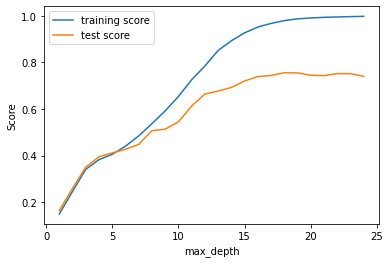

In [ ]:
decision_tree = calculate_tree(DecisionTreeRegressor, 'Decision Tree')

## **Random Forest regression**

Random Forest: Score- training set: 0.981
Random Forest: Score- test set: 0.876

Random Forest: RMSE- training set: 0.16759237686400152
Random Forest: RMSE- testing set: 0.43509681490343766


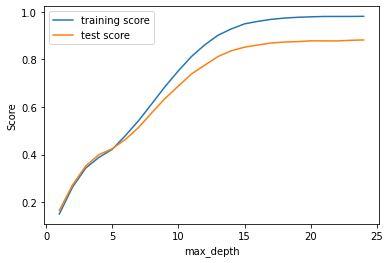

In [ ]:
random_forest_tree = calculate_tree(RandomForestRegressor, 'Random Forest')

## **Multilayer Perceptrons**

In [ ]:
mlp = MLPRegressor(hidden_layer_sizes=([128,128]))
mlp.fit(X_train, y_train)

# Predict
y_test_mlp = mlp.predict(X_test)
y_train_mlp = mlp.predict(X_train)

# Calculate scores
score_train_mlp = mlp.score(X_train, y_train)
score_test_mlp = mlp.score(X_test, y_test)
rmse_train_mlp = np.sqrt(mean_squared_error(y_train, y_train_mlp))
rmse_test_mlp = np.sqrt(mean_squared_error(y_test, y_test_mlp))

# Results
print_results('Multilayer Perceptron Regression',score_train_mlp, score_test_mlp, rmse_train_mlp, rmse_test_mlp)
models_results('Multilayer Perceptron Regression',score_train_mlp, score_test_mlp, rmse_train_mlp, rmse_test_mlp)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Multilayer Perceptron Regression: Score- training set: 0.678
Multilayer Perceptron Regression: Score- test set: 0.668

Multilayer Perceptron Regression: RMSE- training set: 0.6808713352727545
Multilayer Perceptron Regression: RMSE- testing set: 0.7125755347703955


## **XGBoost Regression**

In [ ]:
best_depth = 1
best_score = 0
for depth in range (1,15):
  xgb = XGBRegressor(learning_rate=0.2,max_depth=5)
  xgb.fit(X_train, y_train)

  score_test_xgb = xgb.score(X_test, y_test)
  if best_score < score_test_xgb:
    best_score = score_test_xgb
    best_depth = depth

xgb = XGBRegressor(learning_rate=0.2,max_depth=depth)
xgb.fit(X_train, y_train)

# Predict
y_test_xgb = xgb.predict(X_test)
y_train_xgb = xgb.predict(X_train)

# Calculate scores
score_train_xgb = xgb.score(X_train, y_train)
score_test_xgb = xgb.score(X_test, y_test)
rmse_train_xgb = np.sqrt(mean_squared_error(y_train, y_train_xgb))
rmse_test_xgb = np.sqrt(mean_squared_error(y_test, y_test_xgb))

# Results
print_results('XGBoost Regression',score_train_xgb, score_test_xgb, rmse_train_xgb, rmse_test_xgb)
models_results('XGBoost Regression',score_train_xgb, score_test_xgb, rmse_train_xgb, rmse_test_xgb)

[10:21:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:21:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:21:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:21:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:21:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:21:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:21:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:21:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

## **Comparision of Models**

In [ ]:
results = pd.DataFrame({ 'Model': model_name,
    'Train Score': score_train,
    'Test Score': score_test,
    'Train RMSE': rmse_train,
    'Test RMSE': rmse_test})

results.sort_values(by=['Test Score', 'Train Score'], ascending=False)

,Model,Train Score,Test Score,Train RMSE,Test RMSE
4,Random Forest,0.981,0.876,0.168,0.435
6,XGBoost Regression,0.999,0.872,0.035,0.442
3,Decision Tree,0.980,0.737,0.171,0.633
5,Multilayer Perceptron Regression,0.678,0.668,0.681,0.713
7,Linear Regression,0.191,0.203,1.080,1.103
2,Net3,0.000,-0.000,1.201,1.236
0,Net1,-0.001,-0.002,1.201,1.237
1,Net2,-0.129,-0.131,1.276,1.315


##**Enter Details**

In [ ]:
# Enter patient details

country = input ("Enter country : ")
year = input ("Enter year : ")
sex = input ("Enter gender : ")
age = input ("Enter age : ")

age = int(age)

general_age = "5-14 years"
if age > 14: general_age = "15-24 years"
if age > 24: general_age = "25-34 years"
if age > 34: general_age = "35-54 years"
if age > 54: general_age = "55-74 years"
if age > 74: general_age = "75+ years"



Enter country : Jamaica
Enter year : 1988
Enter gender : female
Enter age : 88


In [ ]:
# Create a dataframe for a specific patient
columns_names = data_before_encoding.columns   # Use the same columns as the original dataframe


country_details = data_before_encoding[(data_before_encoding["country"] == country)]  # Get rows of relevant country
gdp_for_year_avg = country_details["gdp_for_year"].mean()
gdp_per_capita_avg = country_details["gdp_per_capita"].mean()

# Enter patient data to the dataframe
data_before_encoding.iloc[-1]= [country,int(year), sex, general_age, gdp_for_year_avg, gdp_per_capita_avg]


# Categorical features
cat_features=[x for x in data_before_encoding.columns if (data_before_encoding[x].dtype=="str" or data_before_encoding[x].dtype=="object")]
for column in cat_features:
    data_before_encoding[column] = label_encoder.fit_transform(data_before_encoding[column])

# Numerical features
num_features = []
for column in data_before_encoding.columns:
  if column not in cat_features:
    num_features.append(column)

data[num_features] = robust_scaler.fit_transform(data_before_encoding[num_features])

details_as_np = data_before_encoding.values[-1]
patient_details = pd.DataFrame(details_as_np.reshape(-1, len(details_as_np)),columns=columns_names)

# Predict suicide amount per 100k people
pred = random_forest_tree.predict(patient_details)


per_100k = y.to_numpy() # Suicides/100k pop

if pred >= np.percentile(per_100k, 75):
  print("Very High Risk")
else:
  if pred >= np.percentile(per_100k, 50):
    print("High Risk")
  else:
    if pred >= np.percentile(per_100k, 25):
      print("Low Risk")
    else:
        print("Minimum risk")

High Risk


# **Visualizing**

In [ ]:
data = data_for_graphs.copy()
# Average Suicides/100k - Top 10 Countries

data[['country','suicide_per100k']].groupby(['country']).agg('sum').sort_values(by = 'suicide_per100k',
                                                               ascending = False).head(10).style.background_gradient(cmap = 'YlOrRd')

,suicide_per100k
country,
Russian Federation,11305.130000
Lithuania,10588.880000
Hungary,10156.070000
Kazakhstan,9519.520000
Republic of Korea,9350.450000
Austria,9076.230000
Ukraine,8931.660000
Japan,8025.230000
Finland,7924.110000


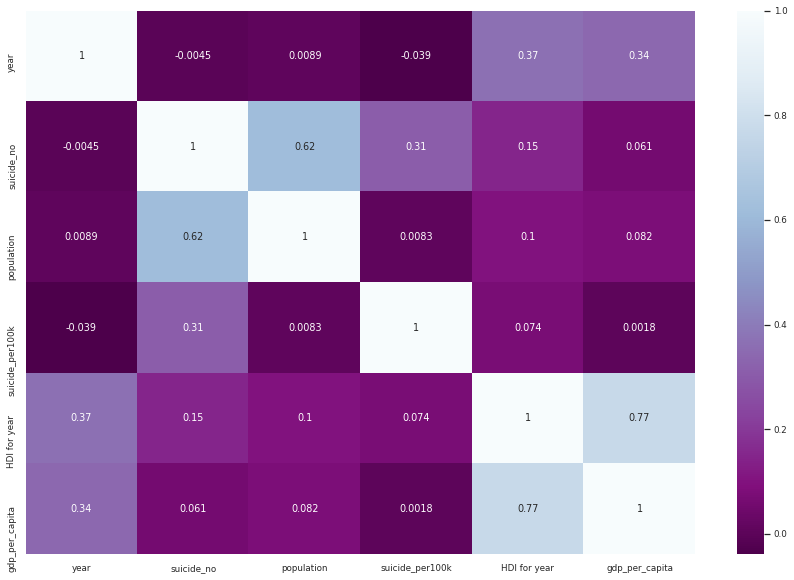

In [ ]:
#Correlation heatmap

plt.figure(figsize=(15,10))
sns.heatmap(data.corr(), annot=True, cmap='BuPu_r')
plt.show()

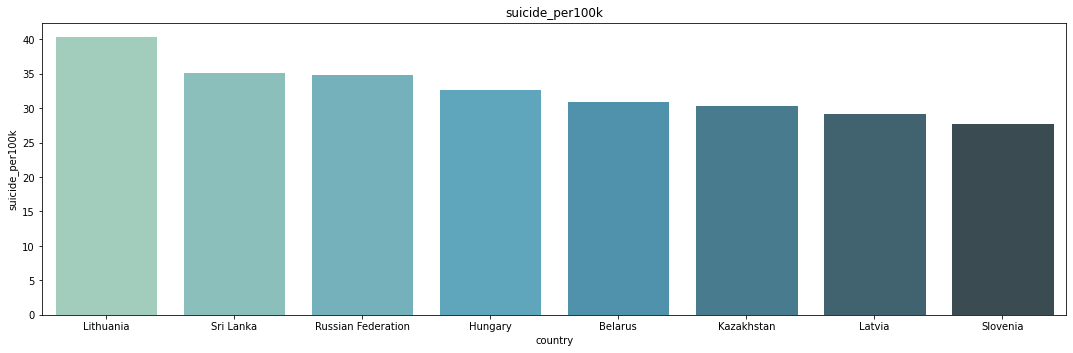

In [ ]:
suic_mean = pd.DataFrame(data['suicide_per100k'].groupby(data['country']).mean())
suic_mean = suic_mean.reset_index()
suic_mean_most = suic_mean.sort_values(by='suicide_per100k',ascending=False).head(8)

fig = plt.figure(figsize=(15,5))
plt.title('suicide_per100k')
sns.set(font_scale=0.8)
sns.barplot(y='suicide_per100k',x='country',data=suic_mean_most,palette="GnBu_d");
plt.ylabel('suicide_per100k')
plt.tight_layout()

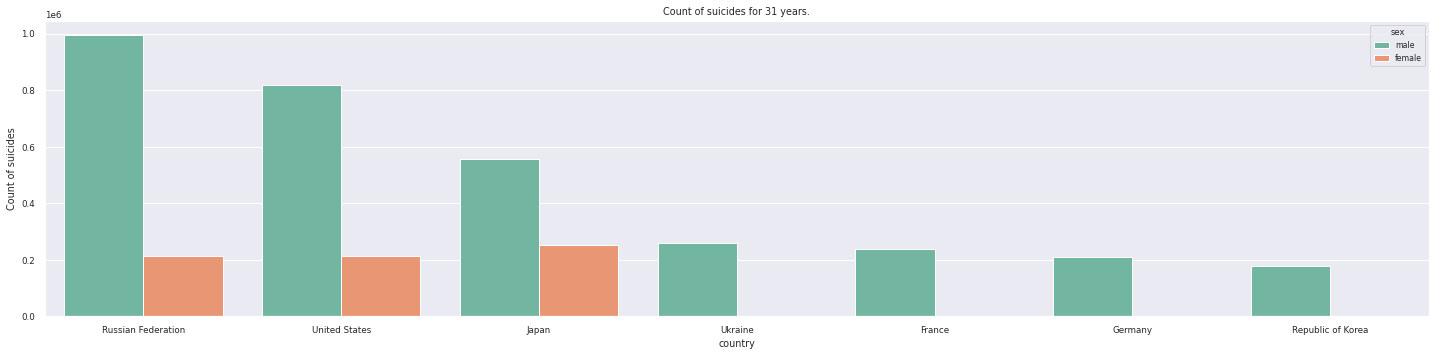

In [ ]:
suic_sum_m = data['suicide_no'].groupby([data['country'],data['sex']]).sum()
suic_sum_m = suic_sum_m.reset_index().sort_values(by='suicide_no',ascending=False)
most_cont_m = suic_sum_m.head(10)
most_cont_m.head(1)
fig = plt.figure(figsize=(20,5))
plt.title('Count of suicides for 31 years.')
sns.set(font_scale=0.7)
sns.barplot(y='suicide_no',x='country',hue='sex',data=most_cont_m,palette='Set2');
plt.ylabel('Count of suicides')
plt.tight_layout()

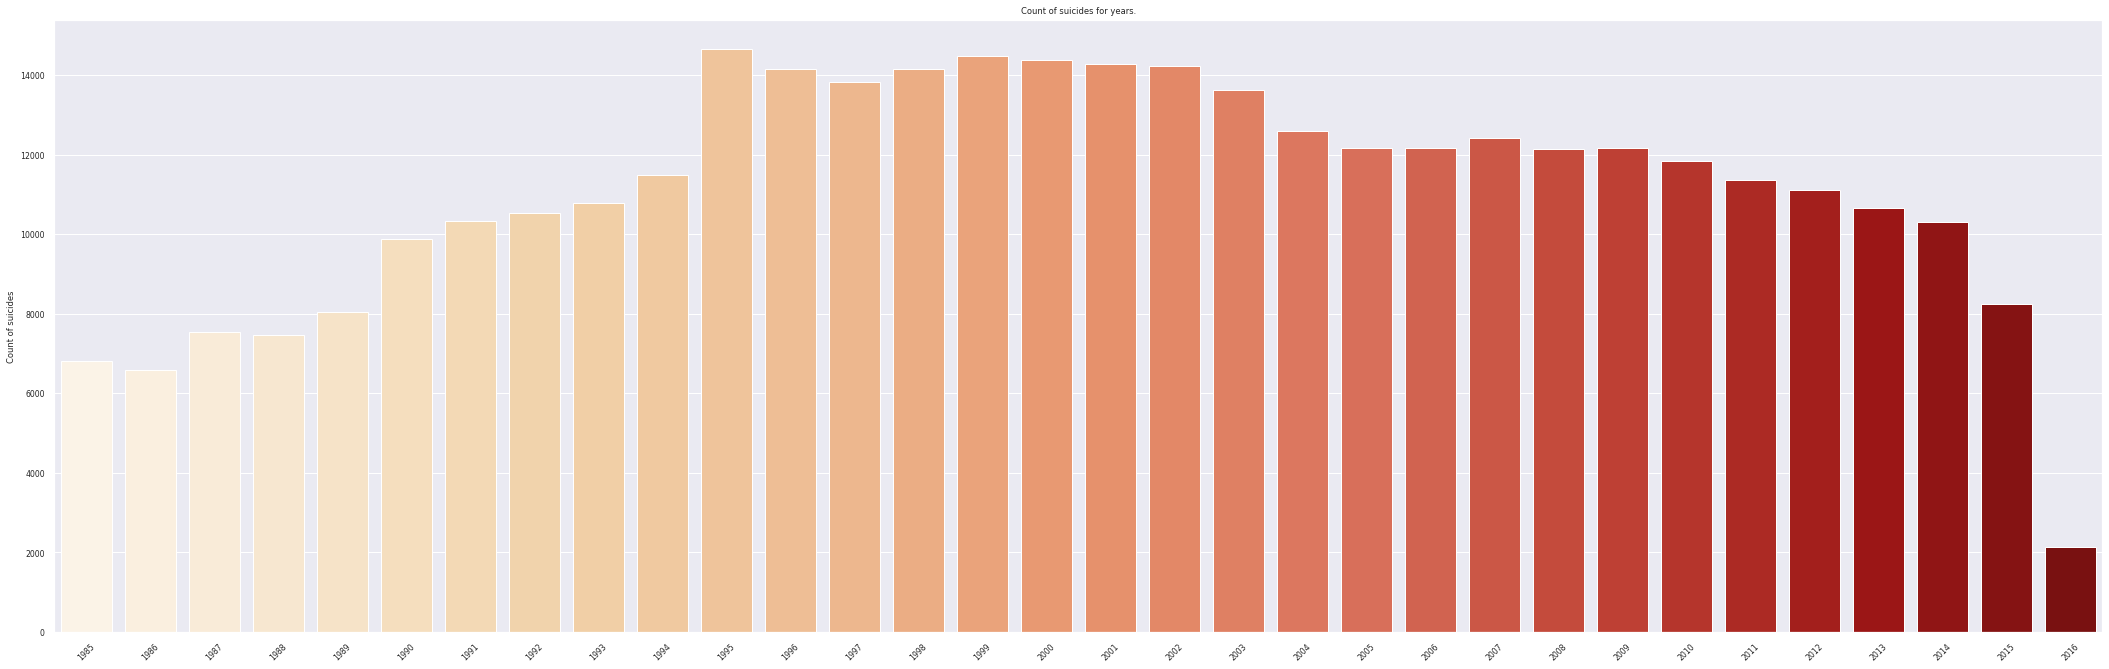

In [ ]:
# Count of suicides by year distribution

suic_sum_yr = pd.DataFrame(data['suicide_per100k'].groupby(data['year']).sum())
suic_sum_yr = suic_sum_yr.reset_index().sort_values(by='suicide_per100k',ascending=False)
most_cont_yr = suic_sum_yr
fig = plt.figure(figsize=(30,10))
plt.title('Count of suicides for years.')
sns.set(font_scale=2.5)
sns.barplot(y='suicide_per100k',x='year',data=most_cont_yr,palette="OrRd");
plt.ylabel('Count of suicides')
plt.xlabel('')
plt.xticks(rotation=45)
plt.tight_layout()

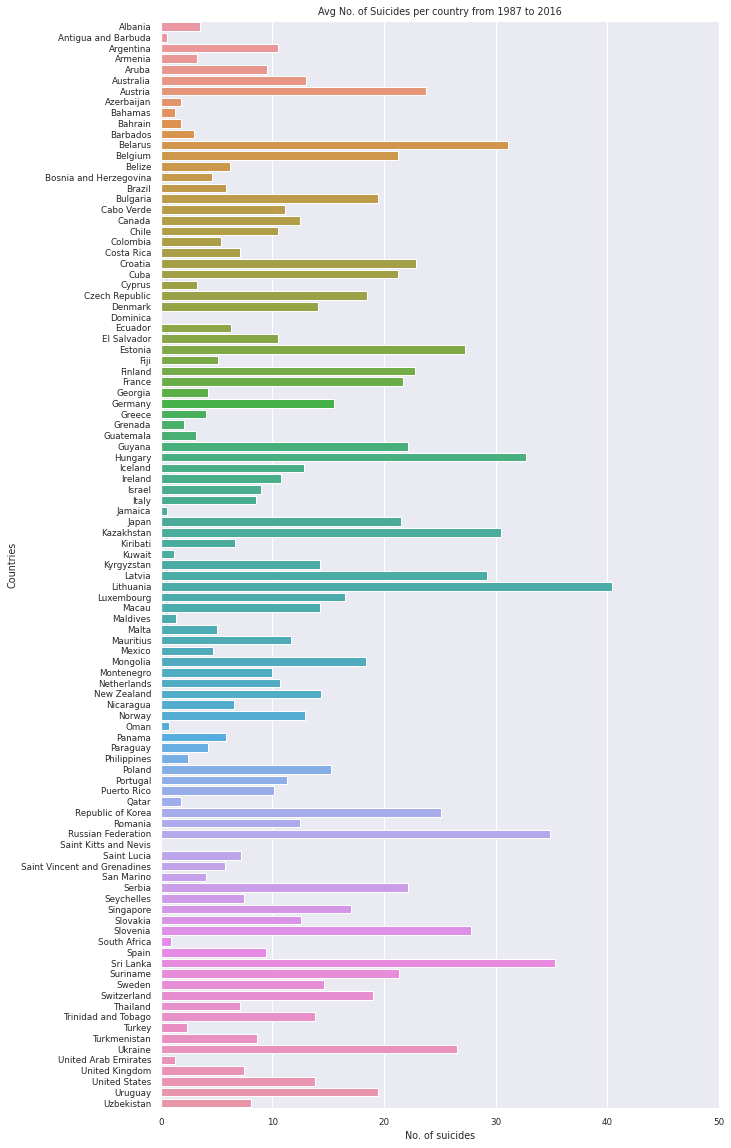

In [ ]:
# Bar Plot avarage No. of Suicides per country last 30 years.

suicide_avg = data.groupby(['country']).suicide_rate.mean()
countries = []
for (i, m) in data.groupby('country'):
    countries.append(i)
countries = np.array(countries);

# ploting
plt.figure(figsize=(10,20))
sns.barplot(y=countries, x=suicide_avg)
plt.xlabel('No. of suicides')
plt.ylabel('Countries')
plt.title('Avg No. of Suicides per country from 1987 to 2016')
plt.xlim(0, 50)
plt.show()

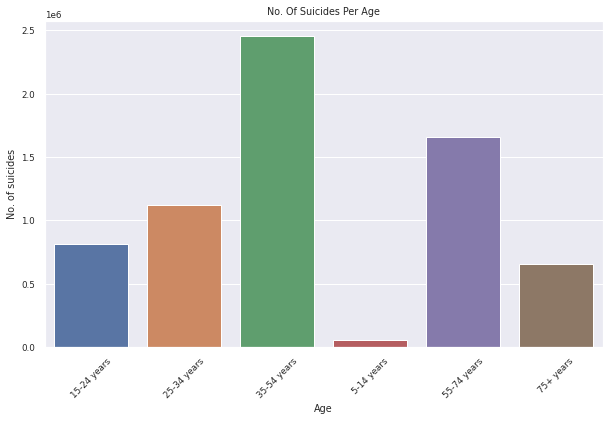

In [ ]:
# Bar Plot No. of Suicides per Age last 30 years.

age_suicide = data.pivot_table('suicide_no', index='age', aggfunc='sum')
x = age_suicide.index.values
y = age_suicide.values
y = y.reshape(6,)

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=x, y=y)
ax.set(title='No. Of Suicides Per Age', ylabel='No. of suicides', xlabel='Age');
plt.xticks(rotation=45);
plt.show()

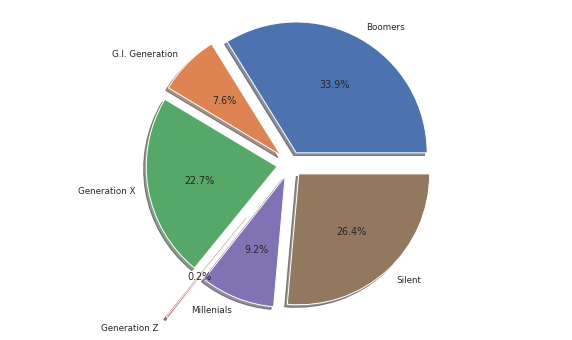

In [ ]:
gen_sui = data.pivot_table('suicide_no', index='generation', aggfunc='sum')
x = gen_sui.index.values
y = gen_sui.values
y = y.reshape(6,)

fig, ax = plt.subplots(figsize=(10, 6))
explode = (0.1,0.1,0.1,0.5,0.1,0.1)
ax.pie(y, explode=explode, labels=x, autopct='%1.1f%%', shadow=True, startangle=0)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()